<a href="https://colab.research.google.com/github/SergheiMihailov/ml-project-cassava/blob/main/ml_project_v2_putting_it_all_together.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Installs
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 10.0MB/s 


In [1]:
# Imports
import gdown
import os
import json
import csv   
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import scipy.misc
import sklearn
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow.keras.layers.experimental.preprocessing as keras_preproc
import kerastuner as kt
import keras
import io
import json
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib.pyplot as plt
import itertools
import numpy as np
import os, shutil
from datetime import datetime
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from collections import Counter
import random

In [2]:
# Constants
# Data
# full = original + augmented
TRAIN_IMAGES_PATH = 'full_train_images/'
TRAIN_LABELS_PATH = 'full_train.csv'
LABEL_TO_DISEASE_MAP_PATH = 'label_num_to_disease_map.json'
CONFUSION_MATRICES_PATH = '/content/drive/MyDrive/ml_project/confusion_matrices/'
MODEL_CP_PATH = '/content/drive/MyDrive/ml_project/models/'

N_CLASSES = 5

# Images
IMG_SIZE = 224
SIZE = (IMG_SIZE,IMG_SIZE)
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Training
EPOCHS_TO_TRAIN = 30
BATCH_SIZE = 32
N_CV_SPLITS = 3


In [3]:
# Downloading data
if not os.path.exists(TRAIN_LABELS_PATH) or not os.path.exists(LABEL_TO_DISEASE_MAP_PATH):
  !gdown --id "1xbEVK_NigW_5ngwKMHvuOTehYhT2v2WF" # original train.csv
  !wget files.brainfriz.com/aug_train.csv         # augmented train.csv
  !wget files.brainfriz.com/full_train.csv        # full train -> augmented + original
  !gdown --id "1SvI9dN2_25c2OlevwK4TjmzBNysjE_PO" # label mapping

if not os.path.exists(TRAIN_IMAGES_PATH):
  !wget files.brainfriz.com/train_images.zip      # original images
  !wget files.brainfriz.com/augmented_images.zip  # augmented images
  os.chdir('/content/')
  !unzip -j -qq -o train_images.zip -d full_train_images
  !unzip -j -qq -o augmented_images.zip -d full_train_images
  

if not os.path.exists('/content/drive/MyDrive/ml_project/'):
  !mkdir /content/drive/MyDrive/ml_project
  
if not os.path.exists(CONFUSION_MATRICES_PATH):
  !mkdir /content/drive/MyDrive/ml_project/confusion_matrices #for the confusion matrix images

if not os.path.exists(MODEL_CP_PATH):
  !mkdir /content/drive/MyDrive/ml_project/models # for saved models

                         image_id  label                           class_name
0                  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1                  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2                   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3                  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4                  1000812911.jpg      3         Cassava Mosaic Disease (CMD)
...                           ...    ...                                  ...
65784  aug_4_10576_1386911368.jpg      4                              Healthy
65785  aug_4_10577_1388871610.jpg      4                              Healthy
65786  aug_4_10578_1389754395.jpg      4                              Healthy
65787  aug_4_10579_1391719532.jpg      4                              Healthy
65788  aug_4_10580_1394172142.jpg      4                              Healthy

[65789 rows x 3 columns]


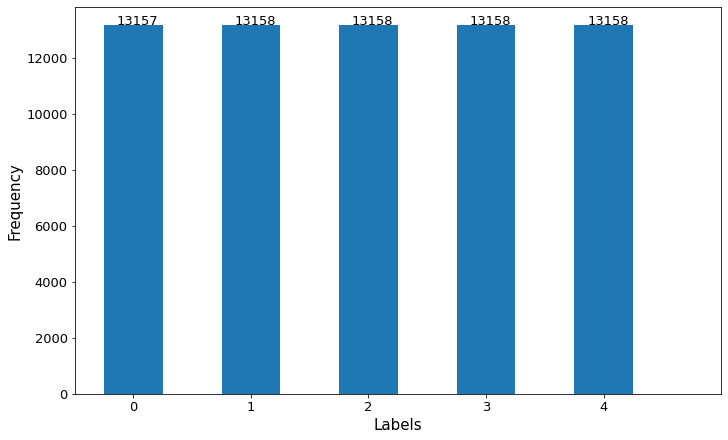

In [4]:
# Dataset
labels = pd.read_csv(TRAIN_LABELS_PATH)
f = open(LABEL_TO_DISEASE_MAP_PATH)
label_class_name = json.load(f)
label_class_name = {int(k):v for k,v in label_class_name.items()}
labels['class_name'] = labels.label.map(label_class_name)

print(labels)

def viewLabelDistribution(labels_list):
  w = 0.5
  label_dist = Counter(labels_list)
  fig, ax = plt.subplots(figsize=(10,6), constrained_layout=True)
  ax.hist(x=labels_list, bins=np.arange(6)-w/2, width=w)
  ax.set_xlabel('Labels', fontsize=15)
  ax.set_ylabel('Frequency', fontsize=15)
  ax.tick_params(axis='both', which='major', labelsize=13)

  i = 0
  for val in range(5):
      ax.text(x=i-0.14, y=int(label_dist[i])+8, s=label_dist[i], fontsize=13)
      i+=1
      
  plt.xticks(ticks=list(range(5)), labels=list(range(5)), rotation=0)
  plt.savefig('disease_distribution.pdf', dpi=100)

viewLabelDistribution(labels['label'])

def getImagesByIds(labels_with_image_id):
  return ImageDataGenerator().flow_from_dataframe(
      labels_with_image_id,
      subset='training',
      directory = TRAIN_IMAGES_PATH,
      x_col = 'image_id',
      y_col = 'class_name',
      target_size = SIZE,
      color_mode='rgb',
      class_mode = 'categorical',
      batch_size = BATCH_SIZE,
      dtype='float16')

def getDatasetsForCrossValidationSplit(n_splits, split_index, shuffle=False, split_size=None):
  kfold = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=42)

  train_indices, val_indices = list(kfold.split(labels['image_id'], labels['label']))[split_index]

  if split_size:
    random.shuffle(train_indices)
    random.shuffle(val_indices)

  if split_size:
    train_indices = train_indices[:split_size*n_splits]
    val_indices = val_indices[:split_size]

  train_ds = labels.iloc[train_indices]
  val_ds = labels.iloc[val_indices]

  viewLabelDistribution(train_ds['label'])
  viewLabelDistribution(val_ds['label'])

  train_set = getImagesByIds(train_ds)
  val_set = getImagesByIds(val_ds)

  return train_set, val_set


In [5]:
# Model definition
def getEfficientNetB3():
  return [
      # architecture
      tf.keras.applications.EfficientNetB3(
        include_top=True, weights=None, input_tensor=None,
        input_shape=INPUT_SHAPE, pooling=None, classes=N_CLASSES,
        classifier_activation='softmax', drop_connect_rate=0.4
      ),
      # preprocess_input
      tf.keras.applications.efficientnet.preprocess_input
  ]

def getResNet50V2(): 
  return [
      # architecture 
      tf.keras.applications.ResNet50V2(
        include_top=True, weights=None, input_tensor=None,
        input_shape=INPUT_SHAPE, pooling=None, classes=N_CLASSES,
        classifier_activation='softmax'
      ),
      # preprocess_input
      tf.keras.applications.resnet_v2.preprocess_input
  ]

def getMobileNetV3Small(): 
  return [
      # architecture
      tf.keras.applications.MobileNetV3Small(
        input_shape=INPUT_SHAPE, alpha=1, minimalistic=True, include_top=True,
        weights=None, input_tensor=None, classes=5, pooling='avg',
        dropout_rate=0, classifier_activation='softmax'
      ),
      # preprocess_input:
      tf.keras.applications.mobilenet_v3.preprocess_input
  ]

def model_builder(hp):
  architecture, preprocess_input = getEfficientNetB3()

  input_layer = preprocess_input(tf.keras.layers.Input(shape=INPUT_SHAPE))

  model = tf.keras.Model(input_layer, architecture(input_layer))
  
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
  hp_label_smoothing = hp.Choice('label_smoothing', values=[1e-3, 1e-4, 1e-5, 0.0])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate, epsilon=0.1),
                loss=keras.losses.CategoricalCrossentropy(label_smoothing=hp_label_smoothing),
                metrics=['accuracy'])

  return model

tuning_callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                patience=5, min_lr=0.00001),
  # tf.keras.callbacks.BaseLogger(
  #   stateful_metrics=None
  # ),
  # tf.keras.callbacks.ProgbarLogger(
  #   count_mode='samples', stateful_metrics=None
  # ),
]

In [ ]:
# Hyperparameter tuning
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=5,
                     factor=3,
                     directory='/content/drive/MyDrive/ml_project/hyperparamseff_net_b3',
                     project_name='cassava'
                     )

train_set, val_set = getDatasetsForCrossValidationSplit(n_splits=N_CV_SPLITS ,split_index=0, shuffle=True, split_size=3000)

# Tune hyperparameters on first cross-validation (refactor later to use saved hps)
tuner.search(train_set, epochs=EPOCHS_TO_TRAIN, validation_data=val_set,callbacks=tuning_callbacks)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters()[0]
print(f"""
The hyperparameter search is complete. Optimal values: \n
learning_rate: {best_hps.get('learning_rate')}; \n
label_smoothing: {best_hps.get('label_smoothing')}; \n
""")

Trial 3 Complete [00h 06m 37s]
val_accuracy: 0.2083333283662796

Best val_accuracy So Far: 0.2226666659116745
Total elapsed time: 00h 19m 48s

Search: Running Trial #4

Hyperparameter    |Value             |Best Value So Far 
learning_rate     |0.1               |0.1               
label_smoothing   |1e-05             |0.0001            
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |1                 |1                 
tuner/round       |0                 |0                 

Epoch 1/2
282/282 [==============================] - 202s 673ms/step - loss: 3.9245 - accuracy: 0.2258 - val_loss: 2.0900 - val_accuracy: 0.2107
Epoch 2/2
171/282 [=================>............] - ETA: 1:06 - loss: 1.8380 - accuracy: 0.2113

In [ ]:
# Evaluation definitions 
class ConfusionMatrix(keras.callbacks.Callback):
  def __init__(self, val_set, val_y):
    self.val_set = val_set
    self.val_y = val_y
    self.counter = 0

  def on_epoch_end(self, epoch, logs=None):
    self.plot()
    self.counter += 1

  def plot(self):
    test_pred_raw = self.model.predict(self.val_set)
    test_pred = np.argmax(test_pred_raw, axis=1)

    cm = sklearn.metrics.confusion_matrix(self.val_y, test_pred)
    self.plot_confusion_matrix(cm, class_names=[0,1,2,3,4])

  def plot_confusion_matrix(self, cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      color = "white" if cm[i, j] > threshold else "black"
      plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(CONFUSION_MATRICES_PATH + 'conf{0}.png'.format(self.counter)) #save file
    plt.close()

# plotter = ConfusionMatrix(val_set, val_set.classes);

In [ ]:
# Training & evaluating the model
best_hps = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hps)

training_callbacks = [
  tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=2, min_lr=0.00001),
  tf.keras.callbacks.ModelCheckpoint(
      MODEL_CP_PATH, monitor='val_loss', verbose=0, save_best_only=False,
      save_weights_only=False, mode='auto', save_freq='epoch',
      options=None
  )
]

for i in range(N_CV_SPLITS):
  train_set, val_set = getDatasetsForCrossValidationSplit(n_splits=N_CV_SPLITS, split_index=i)

  plotter = ConfusionMatrix(val_set, val_set.classes);

  history = model.fit(
        train_set,
        steps_per_epoch=train_set.n // BATCH_SIZE,
        validation_data=val_set,
        epochs=EPOCHS_TO_TRAIN,
        callbacks = [plotter, *training_callbacks]
  )

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Found 43859 validated image filenames belonging to 5 classes.
Found 21930 validated image filenames belonging to 5 classes.
Epoch 1/30
 439/1370 [========>.....................] - ETA: 16:44 - loss: 2.3453 - accuracy: 0.2594

In [ ]:
# The End

In [ ]:
# Our own model